# Operations on Word Vectors


In [ ]:
import numpy as np

In [2]:
def read_glove_vecs(glove_file):
    words=set()
    word_to_vec={}
    with open(glove_file,'r') as f:
        for i,line in enumerate(f):
            l=line.strip().split()
            words.add(l[0])
            word_to_vec[l[0]]=np.array(l[1:],dtype=np.float32)

    return words,word_to_vec

In [3]:
words,word_to_vec_map=read_glove_vecs("data/glove.6B.50d.txt")

- `words`: set of words in the vocabulary.
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation.


## 2 - Embedding Vectors Versus One-Hot Vectors
One-hot vectors don't do a good job of capturing the level of similarity between words. This is because every one-hot vector has the same Euclidean distance from any other one-hot vector.

Embedding vectors, such as GloVe vectors, provide much more useful information about the meaning of individual words.  
Below you can see how to use GloVe vectors to measure the similarity between two words! 

<a name='3'></a>
## 3 - Cosine Similarity

To measure the similarity between two words, you need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$
* $\theta$ is the angle between $u$ and $v$. 
* The cosine similarity depends on the angle between $u$ and $v$. 
    * If $u$ and $v$ are very similar, their cosine similarity will be close to 1.
    * If they are dissimilar, the cosine similarity will take a smaller value. 

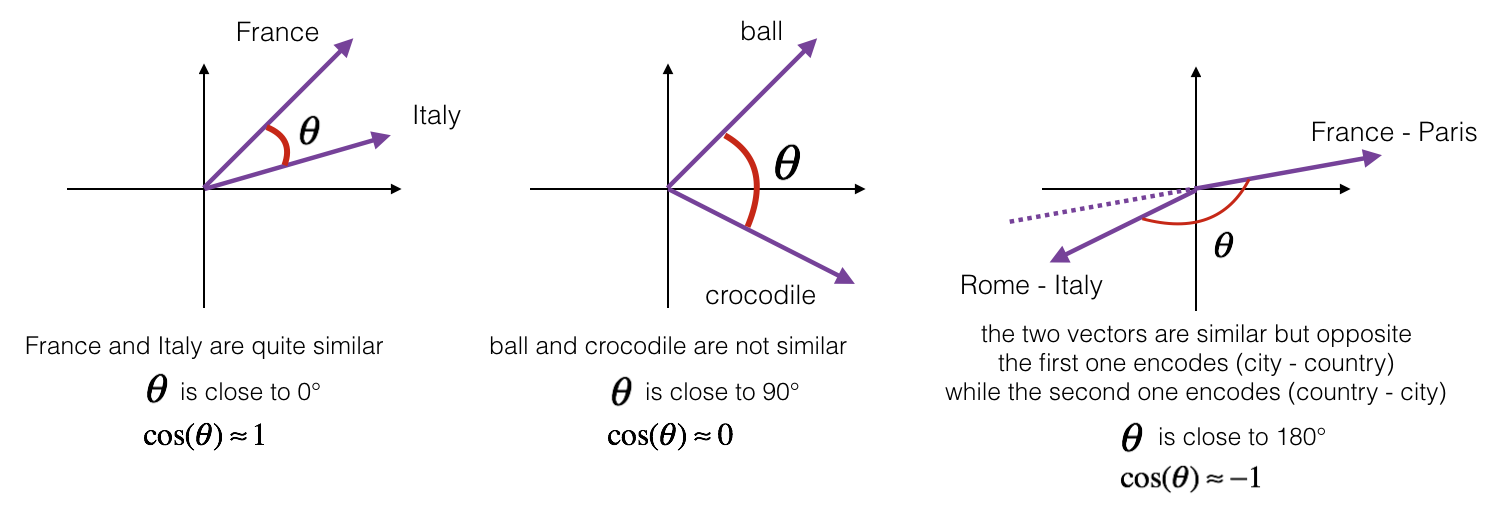

In [18]:
from IPython.display import Image
Image(filename='images/cosine_sim.png',height=300,width=850)

<caption><center><font color='purple'><b>Figure 1</b>: The cosine of the angle between two vectors is a measure of their similarity.</font></center></caption>


The norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

In [6]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    # if u anv are axactly same then return 1
    if np.all((u==v)):
        return 1
    
    numerator=np.dot(u,v)
    
    norm_u=np.sqrt(np.sum(u*u))
    norm_v=np.sqrt(np.sum(v*v))
    
    denominator=norm_u*norm_v
    
    #Avoid division by zero
    if np.isclose(denominator,0,atol=1e-32):
        return 0
    
    cosine_similarity=numerator/denominator # i.e u*v/(norm_u*norm_v) 
    
    return cosine_similarity

In [26]:
#We can see similarity of different words
print("cosine_similarity:")

a,b='king','queen'
print(f"{a},{b} :",cosine_similarity(word_to_vec_map[a],word_to_vec_map[b]))


a,b='ball','animal'
print(f"{a},{b} :",cosine_similarity(word_to_vec_map[a],word_to_vec_map[b]))


a,b='sound','audio'
print(f"{a},{b} :",cosine_similarity(word_to_vec_map[a],word_to_vec_map[b]))


a,b='gold','silver'
print(f"{a},{b} :",cosine_similarity(word_to_vec_map[a],word_to_vec_map[b]))

cosine_similarity:
king,queen : 0.7839044
ball,animal : 0.35434973
sound,audio : 0.61024266
gold,silver : 0.94980466


<a name='4'></a>
## 4 - Word Analogy Task

* In the word analogy task, complete this sentence:  
    <font color='brown'>"*a* is to *b* as *c* is to **____**"</font>. 

* An example is:  
    <font color='brown'> '*man* is to *woman* as *king* is to *queen*' </font>. 

* You're trying to find a word *d*, such that the associated word vectors $e_a, e_b, e_c, e_d$ are related in the following manner:   
    $e_b - e_a \approx e_d - e_c$
* Measure the similarity between $e_b - e_a$ and $e_d - e_c$ using cosine similarity. 


In [28]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    e_a,e_b,e_c=word_to_vec_map[word_a],word_to_vec_map[word_b],word_to_vec_map[word_c]
    
    max_similarity=-100
    best_word=None
    
    for word in word_to_vec_map.keys():
        if word == word_c:
            continue
        
        similarity=cosine_similarity(e_b-e_a , word_to_vec_map[word]-e_c)
        
        if similarity>max_similarity:
            best_word=word
            max_similarity=similarity
            
    return best_word

In [30]:
analogies = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for analogy in analogies:
    print ('{} -> {} :: {} -> {}'.format( *analogy, complete_analogy(*analogy, word_to_vec_map)))


italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> smaller


<a name='5'></a>
## 5 - Debiasing Word Vectors (OPTIONAL/UNGRADED) 

We'll examine gender biases that can be reflected in a word embedding, and explore algorithms for reducing the bias.

Let's see how the GloVe word embeddings relate to gender. Begin by computing a vector $g = e_{woman}-e_{man}$, where $e_{woman}$ represents the word vector corresponding to the word *woman*, and $e_{man}$ corresponds to the word vector corresponding to the word *man*. The resulting vector $g$ roughly encodes the concept of "gender". 

We might get a more accurate representation if you compute $g_1 = e_{mother}-e_{father}$, $g_2 = e_{girl}-e_{boy}$, etc. and average over them, but just using $e_{woman}-e_{man}$ will give good enough results for now.


In [20]:
g1 = word_to_vec_map['woman'] - word_to_vec_map['man']
g2 = word_to_vec_map['girl'] - word_to_vec_map['boy']
g3 = word_to_vec_map['father'] - word_to_vec_map['mother']
g = (g1+g2+g3)/3
print(g)

[-0.148836    0.10399667 -0.25935667 -0.03240333  0.01153333  0.32187
  0.01311333  0.15412333 -0.10357687 -0.19147413  0.15015667 -0.33757
  0.13209367 -0.03451     0.07380333  0.007818   -0.21853667 -0.041751
  0.166667    0.06849     0.28252333  0.077      -0.06684267  0.16454567
 -0.00415333  0.01046667 -0.1744     -0.15400667 -0.07104667  0.20935667
 -0.158      -0.06760633 -0.11513333 -0.15945405  0.06384333 -0.04588633
 -0.2629761   0.13704733 -0.08946667  0.004409   -0.033782   -0.09196333
  0.19811333 -0.15878833 -0.14488    -0.14649667  0.06691     0.05848333
 -0.02217767 -0.04764   ]


Now, consider the cosine similarity of different words with $g$. What does a positive value of similarity mean, versus a negative cosine similarity? 

In [21]:
print ('List of names and their similarities with constructed vector:')

# girls and boys name
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
john -0.16946085693852617
marie 0.26303065150045585
sophie 0.24871678276981557
ronaldo -0.37017955577023626
priya 0.03285230825857449
rahul -0.1650810283913178
danielle 0.012137660583480737
reza -0.012531827116938397
katy 0.03533606697125641
yasmin 0.09001629792186439


As you can see, female first names tend to have a positive cosine similarity with our constructed vector $g$, while male first names tend to have a negative cosine similarity. This is not surprising, and the result seems acceptable. 

Now try with some other words:

In [22]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities:
lipstick 0.00614447590574842
guns -0.1386696335652291
science 0.09060975448034411
arts 0.15814832347438243
literature 0.28964062689017167
warrior -0.13759116413136094
doctor 0.020851269728831195
tree -0.30827826929426794
receptionist 0.11511399011454891
technology -0.07854305273449784
fashion 0.12960338120368148
teacher 0.2003215102669975
engineer 0.07846555321312887
pilot -0.045003830855866
computer -0.1492417650165763
singer 0.07206556655832615


Some these results reflect certain unhealthy gender stereotypes. For example, we see “computer” is negative and is closer in value to male first names, while “literature” is positive and is closer to female first names.

We can reduce the bias of these vectors, using an algorithm due to [Boliukbasi et al., 2016](https://arxiv.org/abs/1607.06520). Note that some word pairs such as "actor"/"actress" or "grandmother"/"grandfather" should remain gender-specific, while other words such as "receptionist" or "technology" should be neutralized, i.e. not be gender-related. We'll have to treat these two types of words differently when debiasing.

<a name='5-1'></a>
### 5.1 - Neutralize Bias for Non-Gender Specific Words 

The figure below should help you visualize what neutralizing does. If you're using a 50-dimensional word embedding, the 50 dimensional space can be split into two parts: The bias-direction $g$, and the remaining 49 dimensions, which is called $g_{\perp}$ here. In linear algebra, we say that the 49-dimensional $g_{\perp}$ is perpendicular (or "orthogonal") to $g$, meaning it is at 90 degrees to $g$. The neutralization step takes a vector such as $e_{receptionist}$ and zeros out the component in the direction of $g$, giving us $e_{receptionist}^{debiased}$. 

Even though $g_{\perp}$ is 49-dimensional, given the limitations of what you can draw on a 2D screen, it's illustrated using a 1-dimensional axis below. 

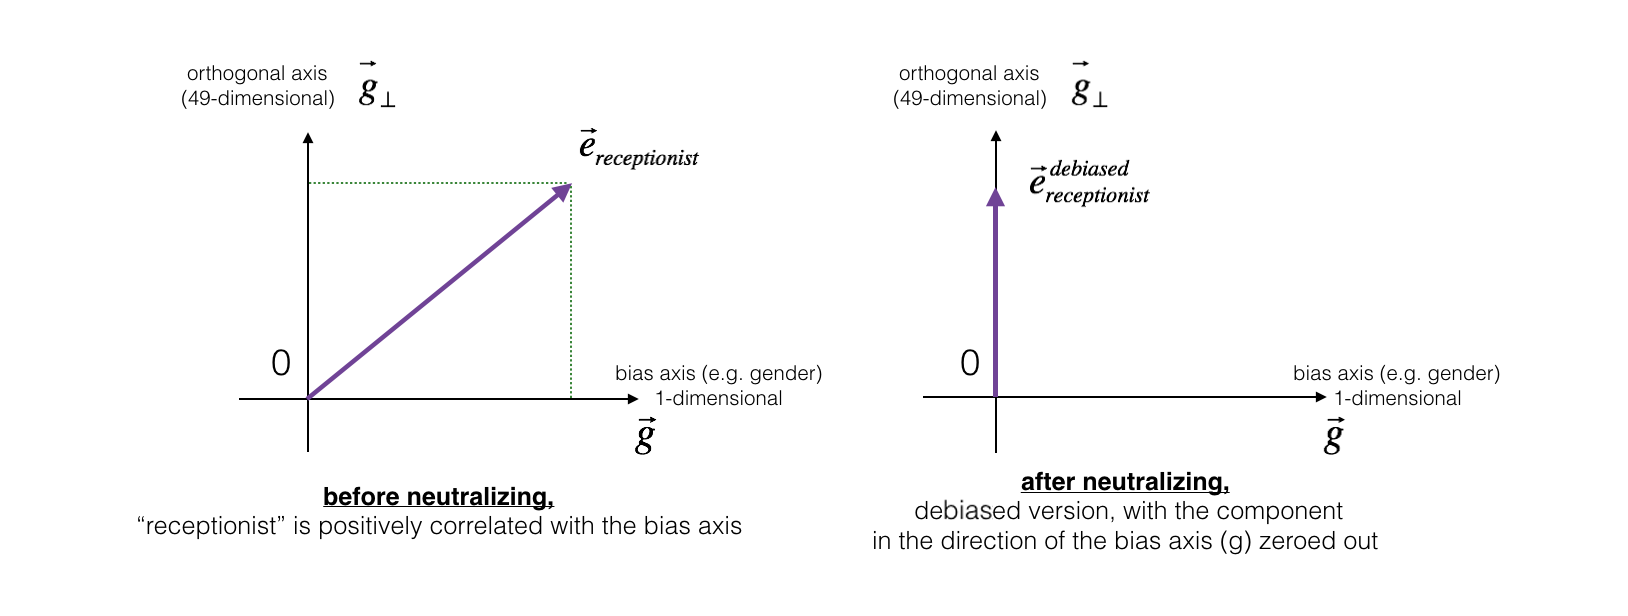

In [22]:
from IPython.display import Image
Image(filename='images/neutral.png',height=300,width=950)

<caption><center><font color='purple'><b>Figure 2</b>: The word vector for "receptionist" represented before and after applying the neutralize operation.</font> </center></caption>

<a name='ex-3'></a>
### Neutralize

Lets Implement `neutralize()` to remove the bias of words such as "receptionist" or "scientist."

Given an input embedding $e$, you can use the following formulas to compute $e^{debiased}$: 

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{2}$$
$$e^{debiased} = e - e^{bias\_component}\tag{3}$$

$e^{bias\_component}$ is the projection of $e$ onto the direction $g$. 
<!-- 
**Reminder**: a vector $u$ can be split into two parts: its projection over a vector-axis $v_B$ and its projection over the axis orthogonal to $v$:
$$u = u_B + u_{\perp}$$
where : $u_B = $ and $ u_{\perp} = u - u_B $
!--> 

In [23]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    
    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.
    
    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """
    
    ### START CODE HERE ###
    # Select word vector representation of "word". Use word_to_vec_map. (≈ 1 line)
    e = word_to_vec_map[word]
    
    # Compute e_biascomponent using the formula given above. (≈ 1 line)
    
    e_biascomponent = (np.dot(e,g)/(np.sum(g*g)))*g
 
    # Neutralize e by subtracting e_biascomponent from it 
    # e_debiased should be equal to its orthogonal projection. (≈ 1 line)
    e_debiased = e - e_biascomponent
    ### END CODE HERE ###
    
    return e_debiased

In [24]:
e = "receptionist"
print("cosine similarity between " + e + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map["receptionist"], g))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("cosine similarity between " + e + " and g, after neutralizing: ", cosine_similarity(e_debiased, g))

cosine similarity between receptionist and g, before neutralizing:  0.11511399011454891
cosine similarity between receptionist and g, after neutralizing:  -3.545719701842963e-18


The second result is essentially 0, up to numerical rounding (on the order of $10^{-17}$).
